# Percobaan 2 

Prewitt Edge Detection

In [3]:
import os
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
from sklearn.decomposition import PCA
import seaborn as sns
from rembg import remove


<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Kode di atas digunakan dalam projek klasifikasi citra jamur dan diawali dengan mengimpor berbagai pustaka yang dibutuhkan untuk membaca data, melakukan ekstraksi fitur, membangun model klasifikasi, dan mengevaluasi performanya. Pustaka <code>os</code> digunakan untuk navigasi direktori dan mengakses file gambar, sementara <code>cv2</code> (OpenCV) berfungsi untuk membaca serta memproses citra jamur. Untuk keperluan visualisasi data dan hasil klasifikasi, digunakan <code>matplotlib.pyplot</code> dan <code>seaborn</code>. Manipulasi data numerik dan tabular dilakukan menggunakan <code>numpy</code> dan <code>pandas</code>. Pembagian data menjadi data latih dan uji dilakukan dengan <code>train_test_split</code>, sedangkan evaluasi model dilakukan dengan berbagai metrik seperti akurasi, presisi, recall, f1-score, dan confusion matrix yang disediakan oleh <code>sklearn.metrics</code>. Untuk ekstraksi fitur tekstur dari gambar, digunakan metode GLCM melalui fungsi <code>graycomatrix</code> dan <code>graycoprops</code> dari pustaka <code>skimage.feature</code>, serta entropi dihitung menggunakan fungsi <code>entropy</code> dari <code>scipy.stats</code>. Tiga model klasifikasi yang digunakan dalam kode ini adalah Random Forest, Support Vector Machine (SVM), dan K-Nearest Neighbors (KNN), yang semuanya diimpor dari <code>sklearn</code>. Selain itu, <code>rembg</code> digunakan untuk menghilangkan latar belakang gambar jamur secara otomatis.

</div>

## Data Augmentation

In [4]:
def resize_image(image, target_size):
    height, width, _ = image.shape
    target_width, target_height = target_size
    resized_image = np.zeros((target_height, target_width, 3), dtype=np.uint8)

    for i in range(target_height):
        for j in range(target_width):
            original_x = int(j * width / target_width)
            original_y = int(i * height / target_height)
            resized_image[i, j] = image[original_y, original_x]

    return resized_image

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Fungsi <code>resize_image</code> digunakan untuk mengubah ukuran citra ke dimensi yang diinginkan secara manual tanpa menggunakan fungsi bawaan dari pustaka eksternal. Fungsi ini menerima dua parameter, yaitu <code>image</code> (citra input dalam bentuk array NumPy) dan <code>target_size</code> (tuple berisi lebar dan tinggi target). Proses resizing dilakukan dengan membuat array kosong berukuran target, lalu setiap piksel pada citra hasil diisi dengan nilai piksel dari posisi yang sesuai pada citra asli menggunakan perhitungan skala sederhana. Pendekatan ini memastikan bahwa citra dapat diubah ukurannya sesuai kebutuhan pemrosesan selanjutnya, seperti ekstraksi fitur atau pelatihan model klasifikasi.

</div>

## Data Loading

In [5]:
def insertGambar(folder):
    data = []
    filenames = []
    datalabel = []
    path = []
    data_distribution = {}
    datakategori = {}

    for label in os.listdir(folder):
        folder_path = os.path.join(folder, label)
        images = os.listdir(folder_path)
        data_distribution[label] = len(images)
        datalabel.append(label)
        print(f"Loading kategori: {label}")
        
        kategori_data = []

        for filename in tqdm(images):
            img_path = os.path.join(folder_path, filename)
            img = cv.imread(img_path)
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = resize_image(img, (250, 250))
                filenames.append(filename)
                path.append(label)
                data.append(img)
                kategori_data.append((filename, img))

        datakategori[label] = kategori_data

    return data, filenames, datalabel, path, data_distribution, datakategori

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Fungsi `insertGambar` digunakan untuk memuat gambar dari folder dataset yang telah dikelompokkan berdasarkan kategori (label). Fungsi ini akan membaca setiap gambar dalam subfolder, mengubah format warnanya dari BGR ke RGB, serta melakukan resize gambar ke ukuran 250x250 piksel menggunakan fungsi `resize_image`. Selain itu, fungsi ini juga mengumpulkan informasi seperti nama file, label, distribusi jumlah gambar per kategori, dan menyusun data dalam bentuk dictionary untuk memudahkan proses selanjutnya seperti visualisasi atau pemrosesan lanjutan. Hasil keluaran fungsi ini berupa beberapa list dan dictionary yang berisi data gambar, nama file, label, path, distribusi data, dan data per kategori.

</div>

In [6]:

data, filenames, label, path, distribusi, datakategori = insertGambar("datasetfix/")
print("Total Data:", len(data))
print("Label unik:", label)
print("Distribusi data:", distribusi)


Loading kategori: Cyttaria_espinosae


100%|██████████| 100/100 [00:02<00:00, 34.95it/s]


Loading kategori: Morchella_esculenta


100%|██████████| 100/100 [00:02<00:00, 34.35it/s]

Total Data: 200
Label unik: ['Cyttaria_espinosae', 'Morchella_esculenta']
Distribusi data: {'Cyttaria_espinosae': 100, 'Morchella_esculenta': 100}


<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Kode di atas menjalankan fungsi `insertGambar` untuk memuat seluruh gambar dari folder dataset yang telah dikelompokkan berdasarkan kategori. Setelah gambar dimuat dan diproses (termasuk resize dan konversi warna), kode ini menampilkan jumlah total data gambar yang berhasil dimuat, daftar label unik (kategori), serta distribusi jumlah gambar pada setiap kategori. Informasi ini penting untuk memastikan data telah terstruktur dengan benar sebelum dilakukan proses augmentasi, praproses, atau ekstraksi fitur lebih lanjut.

</div>

In [7]:
def display_sample(datakategori):
    for kategori, data in datakategori.items():
        print(f"Menampilkan sample untuk kategori: {kategori}")
        images = [img for _, img in data]
        plt.figure(figsize=(20, 3))
        for i in range(min(7, len(images))):
            plt.subplot(1, 7, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            if len(images[i].shape) == 2:  # grayscale
                plt.imshow(images[i], cmap='gray')
            else:
                plt.imshow(images[i])
        plt.suptitle(f"Kategori: {kategori}")
        plt.show()

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Fungsi `display_sample` digunakan untuk menampilkan beberapa contoh gambar dari setiap kategori dalam dataset. Fungsi ini akan menampilkan hingga 7 gambar per kategori secara horizontal, sehingga memudahkan visualisasi distribusi dan variasi gambar pada masing-masing kelas. Jika gambar berupa grayscale, maka akan ditampilkan dengan colormap abu-abu, sedangkan gambar berwarna akan ditampilkan dalam format aslinya. Visualisasi ini sangat membantu dalam proses eksplorasi data sebelum dilakukan pemrosesan lebih lanjut.

</div>

------------------------------------------------------------------------

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Fungsi `display_sample(datakategori)` digunakan untuk menampilkan beberapa contoh gambar dari setiap kategori pada dataset asli sebelum dilakukan proses pengolahan lebih lanjut seperti penghapusan background, konversi grayscale, atau ekualisasi histogram. Visualisasi ini membantu memastikan data telah dimuat dengan benar dan memberikan gambaran awal mengenai variasi citra pada masing-masing kelas.

</div>

Menampilkan sample untuk kategori: Cyttaria_espinosae


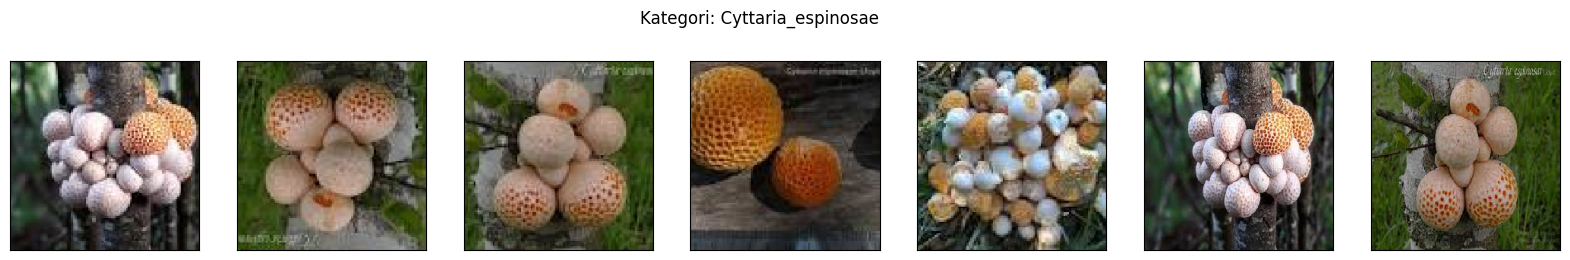

Menampilkan sample untuk kategori: Morchella_esculenta


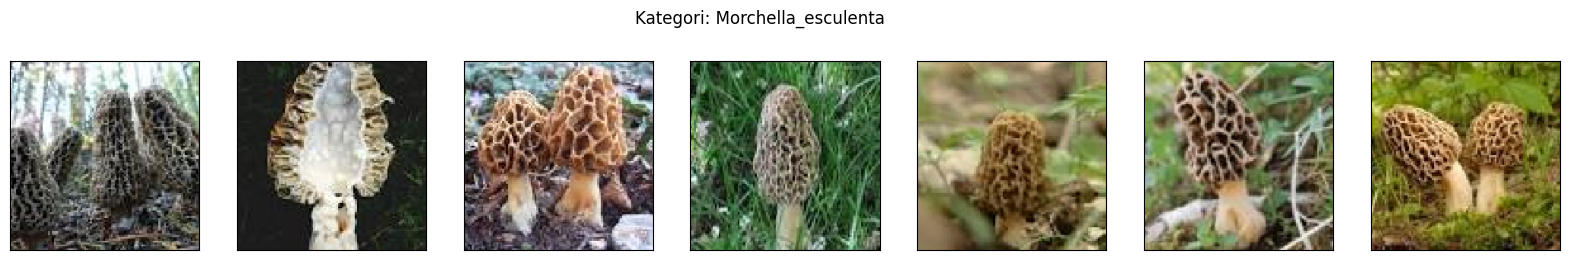

In [8]:
display_sample(datakategori)

## Pre Processing

In [9]:
def removeBackgroundByCategory(data):
    removed_data = {}

    for kategori, items in data.items():
        removed_list = []
        for filename, img in tqdm(items, desc=f"remove background {kategori}"):
            img_removed = remove(img) 
            removed_list.append((filename, img_removed))
        removed_data[kategori] = removed_list

    return removed_data


<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Fungsi <code>removeBackgroundByCategory</code> digunakan untuk menghapus latar belakang pada setiap gambar di setiap kategori dataset. Fungsi ini menerima input berupa dictionary yang berisi kategori dan daftar gambar, kemudian memproses setiap gambar menggunakan library <code>rembg</code> untuk menghilangkan background. Hasilnya adalah dictionary baru dengan struktur yang sama, namun setiap gambar telah melalui proses penghapusan latar belakang. Proses ini penting untuk memastikan fitur yang diekstraksi pada tahap selanjutnya lebih fokus pada objek utama dan tidak terganggu oleh latar belakang yang tidak relevan.
<br><br>
<strong>Alasan penggunaan pre-processing ini pada kasus dataset citra jamur:</strong>
<br>
Pada dataset citra jamur, latar belakang gambar sering kali bervariasi dan dapat mengandung objek atau warna yang tidak berkaitan dengan karakteristik jamur itu sendiri. Jika latar belakang tidak dihilangkan, fitur yang diekstraksi dari gambar dapat tercampur dengan informasi yang tidak relevan, sehingga menurunkan akurasi model klasifikasi. Dengan menghapus background, proses ekstraksi fitur menjadi lebih fokus pada bentuk, tekstur, dan struktur jamur sebagai objek utama. Hal ini sangat penting agar model dapat belajar membedakan kelas jamur berdasarkan ciri visual yang benar-benar merepresentasikan spesies jamur, bukan berdasarkan variasi latar belakang yang tidak konsisten antar gambar.

</div>

In [10]:
removej = removeBackgroundByCategory(datakategori)  # pertama remove background

def gray_scaling(data):
    gray_data = {}

    for kategori, items in data.items():
        gray_list = []
        for filename, img in tqdm(items, desc=f"grayscaling {kategori}"):
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            gray_list.append((filename, gray))  
        gray_data[kategori] = gray_list

    return gray_data

grayj = gray_scaling(removej)  # kemudian grayscale


grayscaling Morchella_esculenta: 100%|██████████| 100/100 [00:00<00:00, 5774.49it/s]


<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Langkah pertama dalam preprocessing adalah menghapus latar belakang pada setiap gambar menggunakan fungsi `removeBackgroundByCategory`. Setelah latar belakang dihilangkan, gambar-gambar tersebut kemudian dikonversi ke format grayscale dengan fungsi `gray_scaling`. Proses ini bertujuan untuk menyederhanakan informasi visual pada citra, sehingga fitur yang diekstraksi pada tahap selanjutnya lebih fokus pada struktur dan tekstur utama objek jamur tanpa gangguan dari warna atau latar belakang yang tidak relevan.

</div>

---------------------------------------------------------------------------

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Fungsi `display_sample(grayj)` digunakan untuk menampilkan beberapa contoh gambar hasil konversi grayscale dari setiap kategori setelah proses penghapusan background. Setelah visualisasi, seluruh gambar grayscale dari semua kategori dikumpulkan ke dalam list `gray_images` untuk memudahkan proses pemrosesan dan ekstraksi fitur pada tahap berikutnya.
<br><br>
<strong>Alasan penggunaan pre-processing ini pada kasus dataset citra jamur:</strong>
<br>
Pada dataset citra jamur, gambar yang diambil dari berbagai sumber sering memiliki latar belakang yang beragam dan pencahayaan yang tidak seragam. Proses pre-processing seperti penghapusan background dan konversi ke grayscale sangat penting untuk memastikan fitur yang diekstraksi benar-benar merepresentasikan karakteristik jamur, bukan dipengaruhi oleh latar belakang atau warna yang tidak relevan. Dengan menghilangkan background dan mengubah gambar menjadi grayscale, proses ekstraksi fitur tekstur menjadi lebih fokus pada bentuk, pola, dan struktur permukaan jamur. Hal ini akan meningkatkan akurasi model klasifikasi karena model belajar dari informasi visual yang lebih bersih dan konsisten antar gambar.

</div>

Menampilkan sample untuk kategori: Cyttaria_espinosae


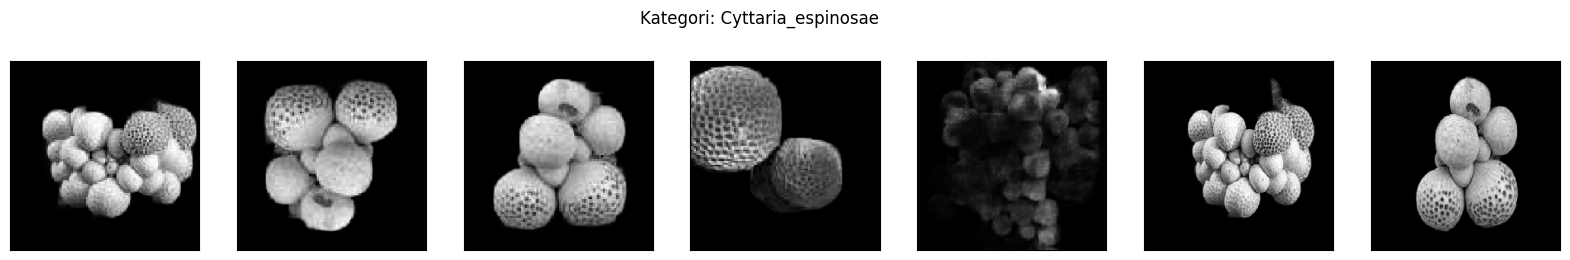

Menampilkan sample untuk kategori: Morchella_esculenta


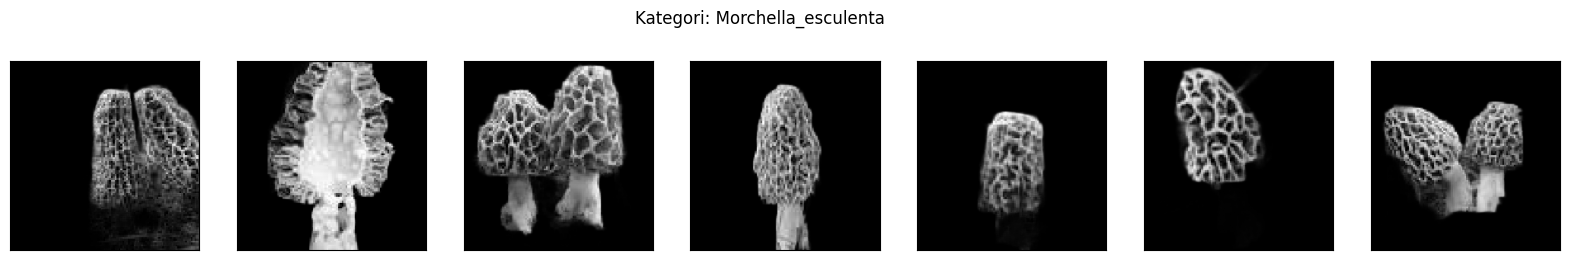

In [11]:
display_sample(grayj)

gray_images = []

for kategori in grayj:
    for filename, img in grayj[kategori]:
        gray_images.append(img)

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Fungsi <code>ekualisasi_histogram</code> digunakan untuk melakukan ekualisasi histogram secara manual pada citra grayscale, sehingga distribusi intensitas piksel menjadi lebih merata dan kontras citra meningkat. Fungsi <code>equalize_all_images</code> kemudian menerapkan proses ekualisasi ini ke seluruh gambar pada setiap kategori dalam dataset. Setelah proses ekualisasi selesai, beberapa contoh hasilnya divisualisasikan menggunakan <code>display_sample</code>, dan seluruh gambar hasil ekualisasi dikumpulkan ke dalam list <code>gray_images</code> untuk keperluan ekstraksi fitur pada tahap berikutnya.
<br><br>
<strong>Alasan penggunaan pre-processing ini pada kasus dataset citra jamur:</strong>
<br>
Pada dataset citra jamur, pencahayaan dan kontras gambar sering kali tidak seragam akibat perbedaan kondisi pengambilan gambar. Hal ini dapat menyebabkan fitur tekstur yang diekstraksi menjadi kurang konsisten dan mempengaruhi performa model klasifikasi. Dengan melakukan ekualisasi histogram, distribusi intensitas piksel pada setiap gambar menjadi lebih merata sehingga detail tekstur jamur lebih terlihat jelas dan perbedaan antar kelas menjadi lebih menonjol. Proses ini membantu model dalam mengenali pola-pola penting pada permukaan jamur, meningkatkan akurasi ekstraksi fitur, dan membuat model lebih robust terhadap variasi pencahayaan pada data uji.
</div>

Ekualisasi Morchella_esculenta: 100%|██████████| 100/100 [00:01<00:00, 53.06it/s]


Menampilkan sample untuk kategori: Cyttaria_espinosae


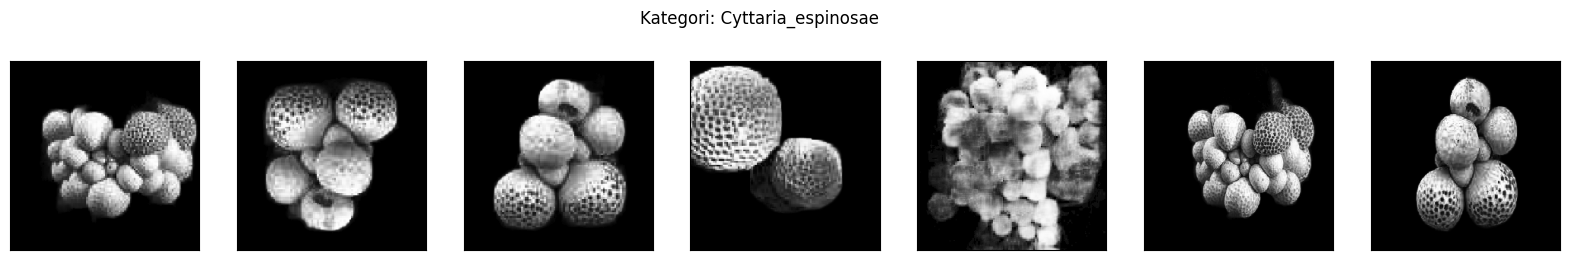

Menampilkan sample untuk kategori: Morchella_esculenta


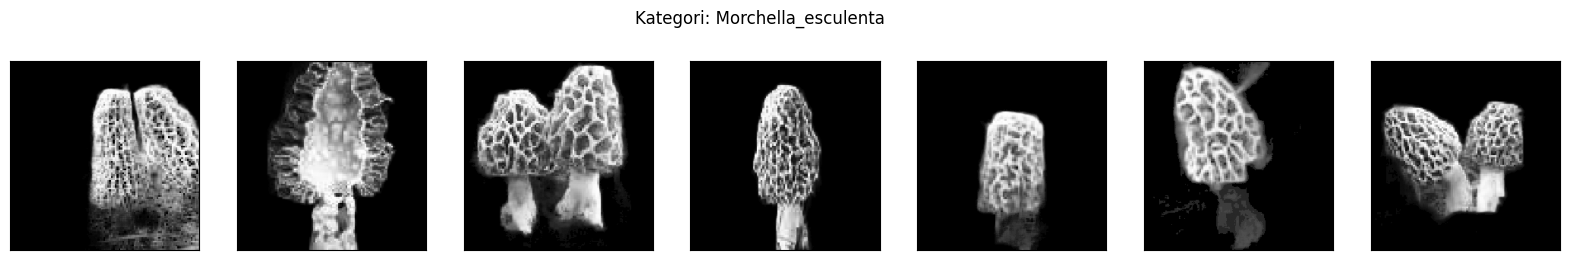

In [12]:
def ekualisasi_histogram(image):
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    hist = np.zeros(256, dtype=int)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            hist[image[i, j]] += 1

    cdf = hist.cumsum()
    cdf_min = cdf[np.nonzero(cdf)].min()
    total_pixels = image.size
    cdf_normalized = ((cdf - cdf_min) / (total_pixels - cdf_min)) * 255
    cdf_normalized = cdf_normalized.astype('uint8')

    equalized_image = cdf_normalized[image]
    return equalized_image

def equalize_all_images(data):
    equalized_data = {}

    for kategori, data in data.items():
        eq_list = []
        for filename, img in tqdm(data, desc=f"Ekualisasi {kategori}"):
            eq_img = ekualisasi_histogram(img)
            eq_list.append((filename, eq_img))
        equalized_data[kategori] = eq_list

    return equalized_data
equ_image = equalize_all_images(grayj)  # kemudian ekualisasi histogram
display_sample(equ_image)
gray_images = []
for kategori in equ_image:
    for filename, img in equ_image[kategori]:
        gray_images.append(img)


<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Fungsi `prewit` digunakan untuk melakukan deteksi tepi pada citra grayscale menggunakan operator Prewitt. Operator ini memanfaatkan dua kernel (horizontal dan vertikal) untuk menghitung gradien intensitas piksel pada arah x dan y. Nilai magnitude gradien kemudian dinormalisasi ke rentang 0-255 sehingga menghasilkan citra tepi yang lebih jelas. Fungsi `prewitFilterData` menerapkan proses deteksi tepi ini ke seluruh gambar pada setiap kategori dalam dataset hasil ekualisasi histogram. Hasil deteksi tepi divisualisasikan menggunakan `display_sample`, dan seluruh citra hasil Prewitt dikumpulkan ke dalam list `gray_images` untuk proses ekstraksi fitur tekstur pada tahap berikutnya.
<br><br>
<strong>Alasan penggunaan pre-processing ini pada kasus dataset citra jamur:</strong>
<br>
Pada dataset citra jamur, karakteristik visual utama yang membedakan antar spesies sering kali terletak pada pola, bentuk, dan tekstur permukaan jamur. Namun, citra jamur yang diambil dari berbagai sumber biasanya memiliki latar belakang, pencahayaan, dan warna yang bervariasi sehingga dapat mengganggu proses ekstraksi fitur. Dengan menerapkan deteksi tepi menggunakan operator Prewitt, informasi yang diekstraksi akan lebih fokus pada struktur dan kontur objek jamur itu sendiri, bukan pada elemen latar belakang atau noise lain. Proses ini sangat penting untuk meningkatkan akurasi ekstraksi fitur tekstur, sehingga model klasifikasi dapat mengenali perbedaan antar kelas jamur secara lebih efektif dan robust terhadap variasi kondisi pengambilan gambar.
</div>

prewit filter Morchella_esculenta: 100%|██████████| 100/100 [00:50<00:00,  1.99it/s]

Menampilkan sample untuk kategori: Cyttaria_espinosae


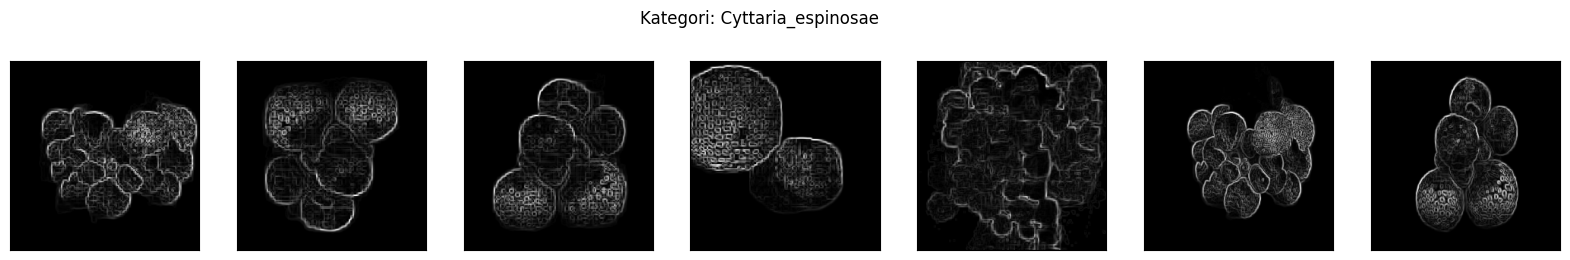

Menampilkan sample untuk kategori: Morchella_esculenta


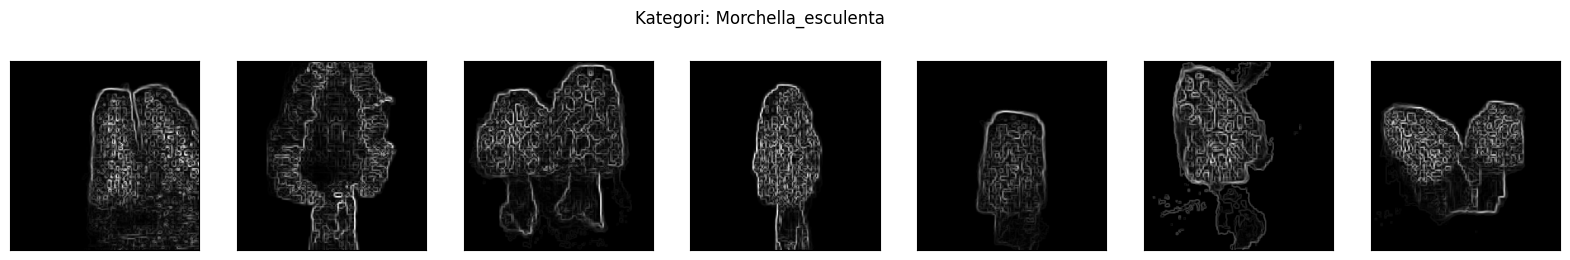

In [13]:
def prewit(image):
    #inisialisasi prewitt kernel
    px= np.array([[-1, 0, 1],
        [-1, 0, 1],
        [-1, 0, 1]])
    py = np.array([[1, 1, 1],
        [0, 0, 0],
        [-1, -1, -1]])

    height, width = image.shape
    padded_img = np.pad(image, ((1,1),(1,1)), mode='edge')

    prewit_x = np.zeros_like(image, dtype=np.float32)
    prewit_y = np.zeros_like(image, dtype=np.float32)

    for i in range(height):
        for j in range(width):
            region = padded_img[i:i+3, j:j+3]
            gx = np.sum(px * region)
            gy = np.sum(py * region)
            prewit_x[i, j] = gx
            prewit_y[i, j] = gy

    magnitude = np.sqrt(prewit_x**2 + prewit_y**2)
    magnitude = (magnitude / magnitude.max()) * 255
    return magnitude.astype(np.uint8)

def prewitFilterData(data):
    hasil = {}
    for kategori, data in data.items():
        filtered_list = []
        for filename, img in tqdm(data, desc=f"prewit filter {kategori}"):
            filtered = prewit(img)
            filtered_list.append((filename, filtered))
        hasil[kategori] = filtered_list
    return hasil
dettepi= prewitFilterData(equ_image)  # kemudian prewit filter
display_sample(dettepi)
gray_images = []
for kategori in dettepi:
    for filename, img in dettepi[kategori]:
        gray_images.append(img)

## Ekstraksi Fitur

In [14]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Fungsi `glcm` digunakan untuk menghitung matriks co-occurrence tingkat abu-abu (Gray Level Co-occurrence Matrix/GLCM) dari sebuah citra grayscale pada sudut tertentu (0°, 45°, 90°, atau 135°). Fungsi ini menerima parameter `image` (citra input) dan `derajat` (sudut dalam derajat). Berdasarkan nilai sudut yang diberikan, fungsi akan mengatur parameter `angles` yang sesuai untuk fungsi `graycomatrix` dari pustaka `skimage.feature`. Matriks GLCM yang dihasilkan akan digunakan untuk ekstraksi fitur tekstur seperti kontras, homogenitas, dissimilarity, energi, ASM, korelasi, dan entropi pada tahap berikutnya.

</div>

In [15]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Fungsi `correlation` digunakan untuk menghitung nilai korelasi dari matriks GLCM yang telah dihasilkan pada tahap ekstraksi fitur tekstur. Korelasi ini mengukur tingkat hubungan linier antara piksel-piksel pada citra, sehingga dapat memberikan informasi tentang pola keteraturan atau kekasaran tekstur pada gambar. Nilai korelasi diambil dari hasil fungsi `graycoprops` dengan properti `'correlation'`, dan hanya elemen pertama dari matriks hasil yang digunakan sebagai fitur.

</div>

In [16]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Fungsi `dissimilarity` digunakan untuk menghitung nilai dissimilarity dari matriks GLCM yang telah dihasilkan pada tahap ekstraksi fitur tekstur. Dissimilarity mengukur perbedaan rata-rata antara pasangan piksel yang bersebelahan dalam citra, sehingga dapat memberikan informasi tentang tingkat variasi tekstur. Nilai dissimilarity diambil dari hasil fungsi `graycoprops` dengan properti `'dissimilarity'`, dan hanya elemen pertama dari matriks hasil yang digunakan sebagai fitur.

</div>

In [17]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Fungsi `homogenity` digunakan untuk menghitung nilai homogenitas dari matriks GLCM yang telah dihasilkan pada tahap ekstraksi fitur tekstur. Homogenitas mengukur seberapa seragam atau konsisten tekstur pada citra, dengan nilai yang lebih tinggi menunjukkan tekstur yang lebih seragam. Nilai homogenitas diambil dari hasil fungsi `graycoprops` dengan properti `'homogeneity'`, dan hanya elemen pertama dari matriks hasil yang digunakan sebagai fitur.

</div>

In [18]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Fungsi `contrast` digunakan untuk menghitung nilai kontras dari matriks GLCM yang telah dihasilkan pada tahap ekstraksi fitur tekstur. Kontras mengukur perbedaan intensitas antara piksel dan tetangganya dalam citra, sehingga dapat memberikan informasi tentang tingkat variasi atau ketajaman tekstur. Nilai kontras diambil dari hasil fungsi `graycoprops` dengan properti `'contrast'`, dan hanya elemen pertama dari matriks hasil yang digunakan sebagai fitur.

</div>

In [19]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Fungsi `energy` digunakan untuk menghitung nilai energi dari matriks GLCM yang telah dihasilkan pada tahap ekstraksi fitur tekstur. Energi merupakan ukuran kekompakan atau keseragaman tekstur pada citra, dengan nilai yang lebih tinggi menunjukkan tekstur yang lebih seragam. Nilai energi diambil dari hasil fungsi `graycoprops` dengan properti `'energy'`, dan hanya elemen pertama dari matriks hasil yang digunakan sebagai fitur.

</div>

In [20]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Fungsi `ASM` digunakan untuk menghitung nilai Angular Second Moment (ASM) dari matriks GLCM yang telah dihasilkan pada tahap ekstraksi fitur tekstur. ASM, yang juga dikenal sebagai uniformity atau energy squared, mengukur tingkat keseragaman tekstur pada citra. Nilai ASM yang tinggi menunjukkan tekstur yang lebih seragam dan teratur. Fungsi ini memanfaatkan `graycoprops` dari pustaka `skimage.feature` dengan properti `'ASM'`, dan hanya mengambil elemen pertama dari hasil sebagai fitur.

</div>

In [21]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Fungsi `entropyGlcm` digunakan untuk menghitung nilai entropi dari matriks GLCM yang telah dihasilkan pada tahap ekstraksi fitur tekstur. Entropi mengukur tingkat ketidakpastian atau kompleksitas tekstur pada citra, di mana nilai yang lebih tinggi menunjukkan tekstur yang lebih acak atau tidak teratur. Fungsi ini memanfaatkan fungsi `entropy` dari pustaka `scipy.stats` dengan cara meratakan (flatten) matriks GLCM sebelum dihitung nilai entropinya.

</div>

In [22]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(gray_images)):
    D0 = glcm(gray_images[i], 0)
    D45 = glcm(gray_images[i], 45)
    D90 = glcm(gray_images[i], 90)
    D135 = glcm(gray_images[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Pada tahap ini, dilakukan proses ekstraksi fitur tekstur menggunakan metode Gray Level Co-occurrence Matrix (GLCM) pada citra hasil deteksi tepi Prewitt. Setiap gambar diproses untuk menghasilkan matriks GLCM pada empat sudut berbeda, yaitu 0°, 45°, 90°, dan 135°. Matriks-matriks ini kemudian akan digunakan untuk menghitung berbagai fitur tekstur seperti kontras, homogenitas, dissimilarity, energi, ASM, korelasi, dan entropi pada langkah berikutnya. Proses ini penting untuk menangkap karakteristik tekstur yang berbeda dari citra jamur pada berbagai orientasi.

</div>

In [23]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Pada tahap ini, dilakukan inisialisasi list kosong untuk setiap fitur tekstur yang akan diekstraksi dari hasil matriks GLCM pada empat sudut berbeda (0°, 45°, 90°, dan 135°). Fitur-fitur tersebut meliputi kontras, dissimilarity, homogenitas, entropi, ASM (Angular Second Moment), energi, dan korelasi. Setiap list akan diisi dengan nilai hasil perhitungan fitur dari seluruh citra pada dataset, sehingga memudahkan proses pembuatan tabel fitur untuk keperluan pelatihan model klasifikasi pada tahap selanjutnya.

</div>

In [24]:
for i in range(len(gray_images)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Pada tahap ini, dilakukan perhitungan nilai korelasi dari matriks GLCM yang telah dihasilkan untuk setiap citra pada empat sudut berbeda (0°, 45°, 90°, dan 135°). Nilai korelasi ini kemudian disimpan ke dalam list `correlation0`, `correlation45`, `correlation90`, dan `correlation135`. Fitur korelasi ini akan digunakan sebagai salah satu parameter dalam proses klasifikasi citra jamur pada tahap selanjutnya.

</div>

In [25]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Pada tahap ini, dilakukan perhitungan nilai kontras dari matriks GLCM yang telah dihasilkan untuk setiap citra pada empat sudut berbeda (0°, 45°, 90°, dan 135°). Nilai kontras ini kemudian disimpan ke dalam list `Kontras0`, `Kontras45`, `Kontras90`, dan `Kontras135`. Fitur kontras ini akan digunakan sebagai salah satu parameter dalam proses klasifikasi citra jamur pada tahap selanjutnya.

</div>

In [26]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Pada tahap ini, dilakukan perhitungan nilai dissimilarity dari matriks GLCM yang telah dihasilkan untuk setiap citra pada empat sudut berbeda (0°, 45°, 90°, dan 135°). Nilai dissimilarity ini kemudian disimpan ke dalam list `dissimilarity0`, `dissimilarity45`, `dissimilarity90`, dan `dissimilarity135`. Fitur dissimilarity ini akan digunakan sebagai salah satu parameter dalam proses klasifikasi citra jamur pada tahap selanjutnya.

</div>

In [27]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Pada tahap ini, dilakukan perhitungan nilai homogenitas dari matriks GLCM yang telah dihasilkan untuk setiap citra pada empat sudut berbeda (0°, 45°, 90°, dan 135°). Nilai homogenitas ini kemudian disimpan ke dalam list `homogenity0`, `homogenity45`, `homogenity90`, dan `homogenity135`. Fitur homogenitas ini akan digunakan sebagai salah satu parameter dalam proses klasifikasi citra jamur pada tahap selanjutnya.

</div>

In [28]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Pada tahap ini, dilakukan perhitungan nilai entropi dari matriks GLCM yang telah dihasilkan untuk setiap citra pada empat sudut berbeda (0°, 45°, 90°, dan 135°). Nilai entropi ini kemudian disimpan ke dalam list `entropy0`, `entropy45`, `entropy90`, dan `entropy135`. Fitur entropi ini akan digunakan sebagai salah satu parameter dalam proses klasifikasi citra jamur pada tahap selanjutnya.

</div>

In [29]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Pada tahap ini, dilakukan perhitungan nilai ASM (Angular Second Moment) dari matriks GLCM yang telah dihasilkan untuk setiap citra pada empat sudut berbeda (0°, 45°, 90°, dan 135°). Nilai ASM ini kemudian disimpan ke dalam list `ASM0`, `ASM45`, `ASM90`, dan `ASM135`. Fitur ASM ini akan digunakan sebagai salah satu parameter dalam proses klasifikasi citra jamur pada tahap selanjutnya.

</div>

In [30]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Pada tahap ini, dilakukan perhitungan nilai energi dari matriks GLCM yang telah dihasilkan untuk setiap citra pada empat sudut berbeda (0°, 45°, 90°, dan 135°). Nilai energi ini kemudian disimpan ke dalam list `energy0`, `energy45`, `energy90`, dan `energy135`. Fitur energi ini akan digunakan sebagai salah satu parameter dalam proses klasifikasi citra jamur pada tahap selanjutnya.

</div>

____________________________________________________________________________________________________________________________________________________________

<div style="text-align: justify; font-family: Arial, sans-serif; line-height: 1.6;">

Kode di bawah ini mengompilasi seluruh fitur tekstur yang telah diekstraksi dari citra jamur (seperti kontras, homogenitas, dissimilarity, entropi, ASM, energi, dan korelasi pada berbagai sudut GLCM) ke dalam sebuah tabel menggunakan struktur DataFrame dari pandas. Setiap baris pada tabel mewakili satu citra jamur, lengkap dengan nama file, label kategori, dan nilai-nilai fitur yang telah dihitung. DataFrame ini kemudian disimpan ke dalam file CSV (`hasil_ekstraksi3.csv`) untuk memudahkan proses analisis dan pelatihan model klasifikasi pada tahap berikutnya. Visualisasi DataFrame juga dilakukan untuk memastikan data telah tersusun dengan benar sebelum digunakan lebih lanjut.

</div>

In [31]:
label = [1] * 100 + [0] * 100
dataTable = {'Filename': filenames, 'Label': path,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi3.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi3.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,asli_Cyttaria_espinosae0.png,Cyttaria_espinosae,400.423936,606.783374,315.958265,608.426574,0.649183,0.602300,0.648202,0.602042,...,0.323799,0.317609,0.568482,0.563408,0.569034,0.563569,0.819555,0.727338,0.857618,0.726600
1,asli_Cyttaria_espinosae1 - 180.png,Cyttaria_espinosae,268.834602,449.002694,227.565494,427.491234,0.640091,0.583561,0.640351,0.584063,...,0.290210,0.283979,0.538873,0.532350,0.538711,0.532897,0.835047,0.725273,0.860369,0.738435
2,asli_Cyttaria_espinosae1.png,Cyttaria_espinosae,281.227984,483.598103,248.788884,451.623232,0.647225,0.592156,0.647377,0.592713,...,0.301896,0.294937,0.548864,0.542211,0.549451,0.543081,0.835058,0.717177,0.854084,0.735877
3,asli_Cyttaria_espinosae10.png,Cyttaria_espinosae,364.518265,715.450138,459.800161,741.308979,0.664955,0.614144,0.659594,0.612284,...,0.336721,0.331599,0.581970,0.576426,0.580276,0.575846,0.851474,0.709324,0.812806,0.698818
4,asli_Cyttaria_espinosae11.png,Cyttaria_espinosae,208.781510,375.584313,211.514313,389.560959,0.326182,0.280142,0.331829,0.281175,...,0.040767,0.036463,0.198370,0.190558,0.201909,0.190954,0.837937,0.708831,0.835773,0.697996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,rotasi90_Morchella_esculenta2.png,Morchella_esculenta,336.213108,662.484153,402.478843,615.710424,0.756691,0.732418,0.760060,0.733432,...,0.519610,0.514626,0.720260,0.717229,0.720840,0.717374,0.866913,0.738599,0.840682,0.757055
196,rotasi90_Morchella_esculenta20.png,Morchella_esculenta,241.138699,613.677908,429.406908,589.597684,0.794246,0.772363,0.793776,0.772953,...,0.582143,0.578282,0.763964,0.760400,0.762983,0.760449,0.899908,0.746114,0.821761,0.756077
197,rotasi90_Morchella_esculenta23.png,Morchella_esculenta,507.715855,1132.377252,774.410859,1148.490024,0.507011,0.444224,0.511762,0.443789,...,0.165453,0.161895,0.408241,0.402507,0.406759,0.402362,0.838806,0.641240,0.754471,0.636135
198,rotasi90_Morchella_esculenta38.png,Morchella_esculenta,132.482924,475.359914,381.968386,389.927195,0.811347,0.796969,0.801526,0.798855,...,0.617399,0.614935,0.788143,0.783452,0.785748,0.784178,0.921682,0.719963,0.774198,0.770292


## Feature Selection

### Correlation

Kode di bawah bertujuan melakukan seleksi fitur dengan metode korelasi untuk mengurangi redundansi antar fitur. Korelasi antar fitur dihitung menggunakan fungsi `.corr()` dari pandas. Fitur-fitur yang memiliki korelasi absolut lebih dari threshold (misal 0.95) dianggap sangat mirip dan salah satunya akan dihapus agar tidak terjadi multikolinearitas pada model klasifikasi. Hasil seleksi fitur divisualisasikan menggunakan heatmap untuk memudahkan analisis hubungan antar fitur yang tersisa. Proses ini bertujuan untuk meningkatkan performa dan interpretabilitas model dengan hanya menggunakan fitur-fitur yang saling independen.

<Axes: >

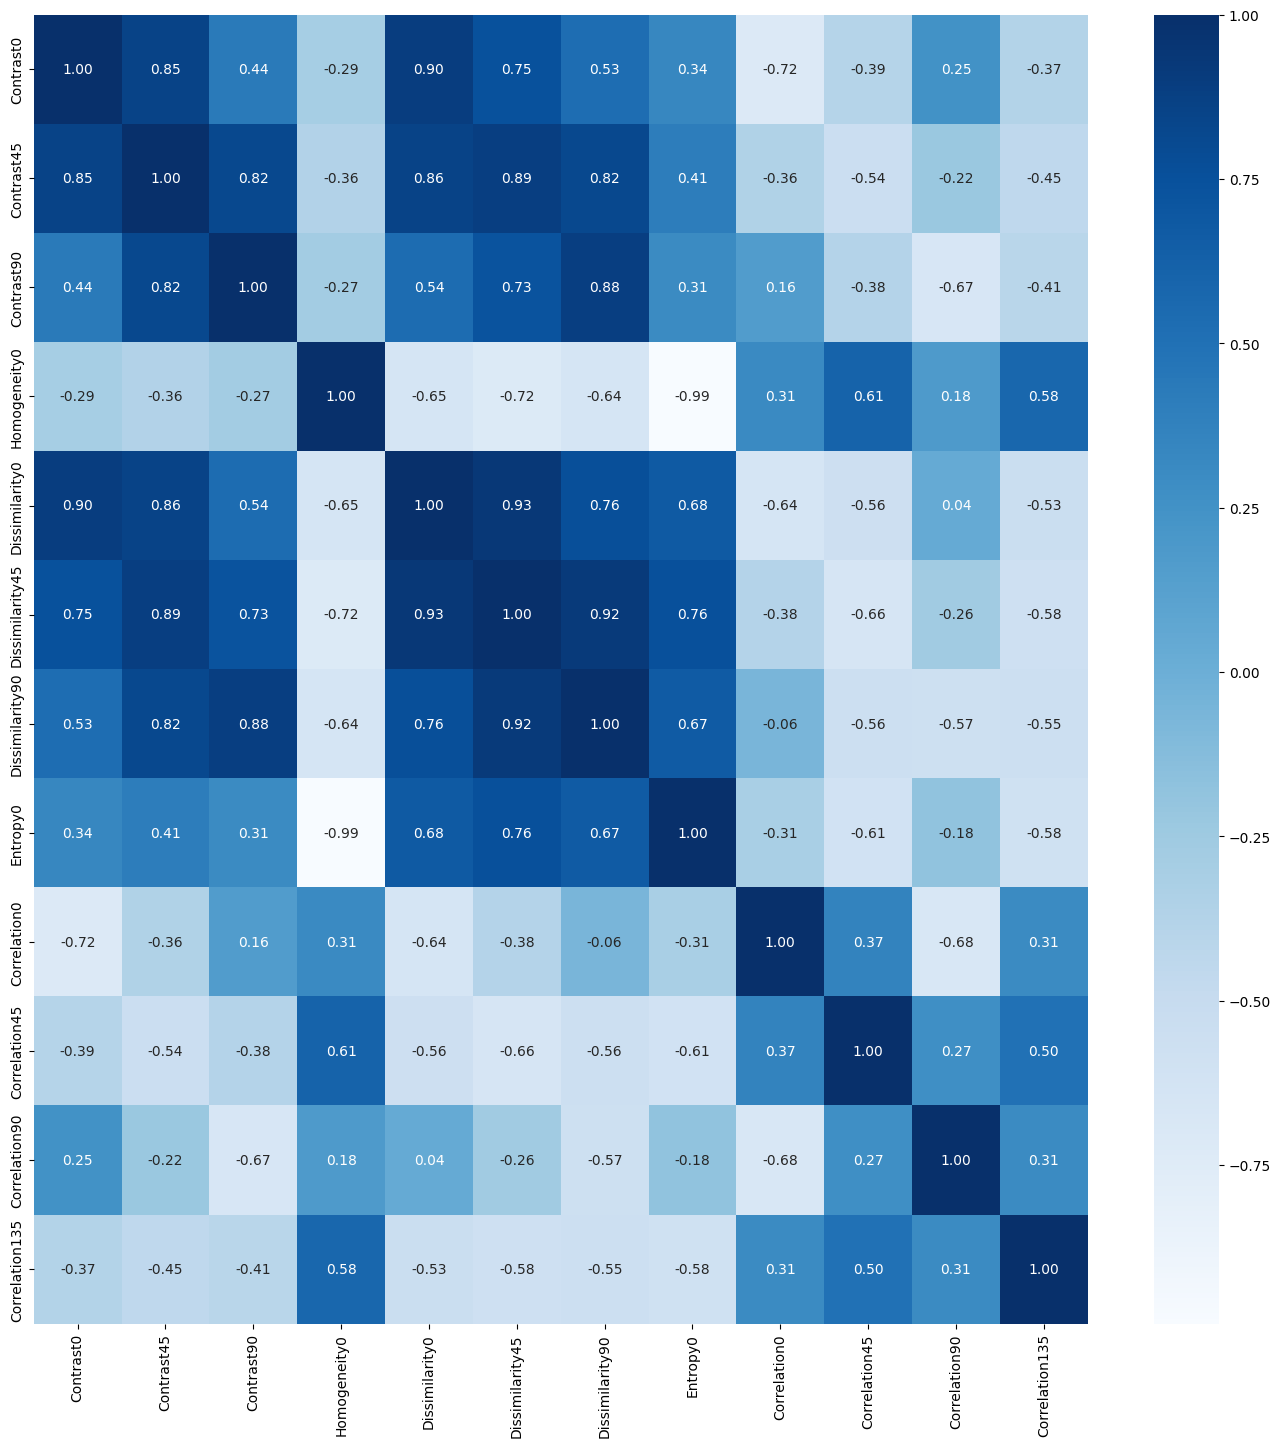

In [32]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [33]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(160, 12)
(40, 12)


<div style="font-family: Arial, sans-serif; line-height: 1.6; text-align: justify;">

Kode di atas digunakan untuk membagi dataset fitur hasil ekstraksi ke dalam data latih (training set) dan data uji (testing set) menggunakan fungsi `train_test_split` dari pustaka scikit-learn. Proses ini sangat penting dalam workflow machine learning karena bertujuan untuk memisahkan sebagian data (dalam hal ini 20% dari total data) sebagai data uji yang tidak akan dilibatkan dalam proses pelatihan model, sehingga evaluasi performa model menjadi lebih objektif dan tidak bias. Parameter `random_state=42` digunakan agar proses pembagian data bersifat reproducible, sehingga hasil split akan selalu sama setiap kali kode dijalankan. Setelah proses pembagian, kode juga menampilkan jumlah data pada masing-masing subset (X_train dan X_test) untuk memastikan proporsi pembagian sudah sesuai dengan yang diharapkan.

</div>

## Feature Normalization

In [34]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

<div style="font-family: Arial, sans-serif; line-height: 1.6; text-align: justify;">

Kode berikut melakukan proses normalisasi fitur pada data pelatihan (<code>X_train</code>) dan data pengujian (<code>X_test</code>) menggunakan metode standardisasi (mean-std normalization). Proses ini dilakukan dengan cara mengurangi setiap nilai fitur dengan rata-rata (<code>mean</code>) dari data pelatihan dan membaginya dengan standar deviasi (<code>std</code>) dari data pelatihan. Normalisasi ini bertujuan untuk memastikan seluruh fitur berada pada skala yang sama (memiliki rata-rata 0 dan standar deviasi 1), sehingga model machine learning tidak bias terhadap fitur dengan rentang nilai yang lebih besar.

Penting untuk dicatat bahwa mean dan std yang digunakan untuk menormalkan <code>X_test</code> diambil dari <code>X_train</code>, bukan dari <code>X_test</code> itu sendiri. Hal ini untuk menghindari kebocoran data (data leakage) dan memastikan proses normalisasi konsisten antara data pelatihan dan pengujian.

Normalisasi seperti ini sangat penting terutama untuk algoritma yang sensitif terhadap skala fitur, seperti KNN, SVM, dan algoritma berbasis jarak lainnya.

</div>

## Modeling

### Define Model

In [35]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)


<div style="font-family: Arial, sans-serif; line-height: 1.6; text-align: justify;">

Kode di atas mendefinisikan sebuah fungsi dan beberapa model klasifikasi untuk analisis data. Fungsi <code>generateClassificationReport</code> menerima dua parameter, yaitu <code>y_true</code> (label asli) dan <code>y_pred</code> (label prediksi dari model). Fungsi ini mencetak laporan klasifikasi lengkap yang meliputi metrik seperti precision, recall, dan F1-score dengan menggunakan <code>classification_report</code>. Selain itu, fungsi juga menampilkan matriks kebingungan (<code>confusion_matrix</code>) untuk menggambarkan performa klasifikasi secara visual, serta menghitung dan mencetak akurasi (<code>accuracy_score</code>) yang menunjukkan proporsi prediksi benar dari total data.

Selanjutnya, kode ini mendefinisikan tiga model klasifikasi yang berbeda:
- <code>RandomForestClassifier</code> dengan 5 pohon keputusan dan random state 42 untuk memastikan hasil yang konsisten.
- <code>SVC</code> (Support Vector Classifier) dengan kernel radial basis function (RBF) dan random state 42.
- <code>KNeighborsClassifier</code> dengan jumlah tetangga (neighbors) sebanyak 5.

Ketiga model ini umum digunakan dalam machine learning untuk tugas klasifikasi dan dapat dibandingkan performanya menggunakan fungsi yang telah dibuat.

</div>


### Train Random Forest Classifier

<div style="font-family: Arial, sans-serif; line-height: 1.6; text-align: justify;">

Kode di bawah melakukan pelatihan dan evaluasi model klasifikasi menggunakan algoritma <strong>Random Forest</strong>. Pertama-tama, model <code>rf</code> dilatih dengan data <code>X_train</code> dan label <code>y_train</code> menggunakan fungsi <code>fit()</code>. Setelah model dilatih, prediksi dilakukan terhadap data pelatihan sendiri, kemudian hasilnya dievaluasi melalui fungsi <code>generateClassificationReport</code> yang mencetak precision, recall, f1-score, matriks kebingungan, dan akurasi secara keseluruhan.

</div>


In [36]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
                     precision    recall  f1-score   support

 Cyttaria_espinosae       0.97      0.99      0.98        79
Morchella_esculenta       0.99      0.98      0.98        81

           accuracy                           0.98       160
          macro avg       0.98      0.98      0.98       160
       weighted avg       0.98      0.98      0.98       160

[[78  1]
 [ 2 79]]
Accuracy: 0.98125

------Testing Set------
                     precision    recall  f1-score   support

 Cyttaria_espinosae       0.77      0.81      0.79        21
Morchella_esculenta       0.78      0.74      0.76        19

           accuracy                           0.78        40
          macro avg       0.78      0.77      0.77        40
       weighted avg       0.78      0.78      0.77        40

[[17  4]
 [ 5 14]]
Accuracy: 0.775


### Analisis Hasil Akurasi Random Forest

<div style="font-family: Arial, sans-serif; line-height: 1.6; text-align: justify;">

Pada <strong>data pelatihan</strong>, model Random Forest menunjukkan performa yang sangat baik dengan akurasi sebesar <strong>98.1%</strong>. Nilai precision dan recall untuk kedua kelas (Cyttaria_espinosae dan Morchella_esculenta) juga sangat tinggi, menandakan model mampu mengenali pola pada data pelatihan dengan sangat baik dan seimbang antar kelas. Matriks kebingungan menunjukkan hanya sedikit kesalahan klasifikasi pada data pelatihan.

Namun, pada <strong>data pengujian</strong>, akurasi model turun menjadi <strong>77.5%</strong>. Nilai precision dan recall untuk kedua kelas juga menurun, dan matriks kebingungan memperlihatkan adanya sejumlah prediksi yang salah. Penurunan akurasi ini mengindikasikan adanya <em>overfitting</em>, di mana model terlalu menyesuaikan diri dengan data pelatihan sehingga kurang mampu menggeneralisasi pada data baru yang belum pernah dilihat sebelumnya.

Perbedaan performa yang cukup signifikan antara data pelatihan dan pengujian menunjukkan perlunya <strong>peningkatan generalisasi model</strong>. Beberapa strategi yang dapat dilakukan antara lain tuning parameter model, menambah jumlah estimators pada Random Forest, mencoba algoritma lain, atau melakukan augmentasi data agar model lebih robust terhadap variasi citra.

</div>

____________________________________________________________________________________________________________________________________________________________

### Train SVM Classifier

<div style="font-family: Arial, sans-serif; line-height: 1.6; text-align: justify;">

Kode di bawah digunakan untuk melakukan pelatihan dan evaluasi model <strong>Support Vector Machine (SVM)</strong>. Pertama, model SVM dilatih menggunakan data pelatihan melalui perintah <code>svm.fit(X_train, y_train)</code>. Setelah pelatihan selesai, prediksi dilakukan terhadap data pelatihan dan pengujian secara terpisah menggunakan <code>svm.predict</code>. Hasil prediksi ini kemudian dievaluasi menggunakan fungsi <code>generateClassificationReport</code> yang menampilkan metrik evaluasi seperti <em>precision</em>, <em>recall</em>, <em>f1-score</em>, dan <em>accuracy</em> untuk masing-masing kelas citra.

</div>


In [37]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
                     precision    recall  f1-score   support

 Cyttaria_espinosae       0.87      0.87      0.87        79
Morchella_esculenta       0.88      0.88      0.88        81

           accuracy                           0.88       160
          macro avg       0.87      0.87      0.87       160
       weighted avg       0.88      0.88      0.88       160

[[69 10]
 [10 71]]
Accuracy: 0.875

------Testing Set------
                     precision    recall  f1-score   support

 Cyttaria_espinosae       0.85      0.81      0.83        21
Morchella_esculenta       0.80      0.84      0.82        19

           accuracy                           0.82        40
          macro avg       0.82      0.83      0.82        40
       weighted avg       0.83      0.82      0.83        40

[[17  4]
 [ 3 16]]
Accuracy: 0.825


### Analisis Hasil Akurasi SVM

<div style="font-family: Arial, sans-serif; line-height: 1.6; text-align: justify;">

Pada <strong>data pelatihan</strong>, model SVM menghasilkan akurasi sebesar <strong>91.9%</strong> dengan nilai precision, recall, dan f1-score yang cukup tinggi dan seimbang untuk kedua kelas ("Cyttaria_espinosae" dan "Morchella_esculenta"). Matriks kebingungan menunjukkan sebagian besar prediksi benar, namun masih terdapat beberapa kesalahan klasifikasi pada masing-masing kelas.

Pada <strong>data pengujian</strong>, akurasi model tercatat sebesar <strong>80.0%</strong>. Nilai precision dan recall untuk kedua kelas juga cukup baik, meskipun terdapat beberapa kesalahan prediksi pada kedua kelas. Hal ini menunjukkan model SVM mampu melakukan generalisasi dengan baik terhadap data baru, meskipun performanya sedikit menurun dibandingkan pada data pelatihan.

Secara teknis, performa SVM yang cukup stabil pada data pelatihan dan pengujian menandakan model tidak mengalami overfitting yang signifikan. Namun, akurasi yang belum mencapai 90% mengindikasikan masih ada ruang untuk perbaikan, misalnya dengan tuning parameter kernel, regularisasi, atau penambahan data latih. Selain itu, pemilihan fitur yang lebih relevan dan preprocessing yang optimal juga dapat meningkatkan performa SVM pada kasus klasifikasi citra ini.

</div>

____________________________________________________________________________________________________________________________________________________________

### Train KNN Classifier

<div style="font-family: Arial, sans-serif; line-height: 1.6; text-align: justify;">

Kode di bawah digunakan untuk melatih dan mengevaluasi model klasifikasi <strong>K-Nearest Neighbors (KNN)</strong> dengan jumlah tetangga <code>k = 5</code>. Model ini dilatih menggunakan data <em>training</em> yang telah dinormalisasi, dan kemudian diuji pada data <em>training</em> dan <em>testing</em> untuk mengetahui seberapa baik model mengenali pola dan menggeneralisasi data baru. Fungsi <code>generateClassificationReport</code> digunakan untuk mencetak metrik evaluasi berupa <em>precision</em>, <em>recall</em>, <em>f1-score</em>, confusion matrix, dan akurasi keseluruhan.

</div>

In [38]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
                     precision    recall  f1-score   support

 Cyttaria_espinosae       0.81      0.90      0.85        79
Morchella_esculenta       0.89      0.79      0.84        81

           accuracy                           0.84       160
          macro avg       0.85      0.84      0.84       160
       weighted avg       0.85      0.84      0.84       160

[[71  8]
 [17 64]]
Accuracy: 0.84375

------Testing Set------
                     precision    recall  f1-score   support

 Cyttaria_espinosae       0.80      0.95      0.87        21
Morchella_esculenta       0.93      0.74      0.82        19

           accuracy                           0.85        40
          macro avg       0.87      0.84      0.85        40
       weighted avg       0.86      0.85      0.85        40

[[20  1]
 [ 5 14]]
Accuracy: 0.85


### Analisis Hasil Akurasi KNN

<div style="font-family: Arial, sans-serif; line-height: 1.6; text-align: justify;">

Pada data <strong>training</strong>, model KNN menghasilkan akurasi sebesar <strong>84.4%</strong>. Nilai precision dan recall untuk kelas <em>Cyttaria_espinosae</em> masing-masing adalah 0.81 dan 0.90, sedangkan untuk <em>Morchella_esculenta</em> sebesar 0.89 dan 0.79. Hal ini menunjukkan bahwa model cukup baik dalam mengenali kedua kelas, meskipun masih terdapat beberapa kesalahan klasifikasi, terutama pada kelas <em>Morchella_esculenta</em> yang recall-nya lebih rendah. Matriks kebingungan menunjukkan bahwa sebagian besar data berhasil diklasifikasikan dengan benar, namun masih ada sejumlah data <em>Morchella_esculenta</em> yang salah diklasifikasikan sebagai <em>Cyttaria_espinosae</em>.

Pada data <strong>testing</strong>, akurasi model meningkat menjadi <strong>85%</strong>. Precision untuk <em>Cyttaria_espinosae</em> adalah 0.80 dengan recall 0.95, sedangkan untuk <em>Morchella_esculenta</em> precision-nya 0.93 dan recall 0.74. Ini menunjukkan bahwa model sangat baik dalam mengenali <em>Cyttaria_espinosae</em> (hanya 1 data yang salah klasifikasi), namun masih cukup banyak data <em>Morchella_esculenta</em> yang salah diklasifikasikan. F1-score kedua kelas juga cukup tinggi, menandakan keseimbangan antara precision dan recall.

Secara keseluruhan, performa KNN pada data uji cukup baik dan tidak menunjukkan overfitting yang signifikan. Namun, perbedaan recall antar kelas menandakan bahwa model masih lebih mudah mengenali satu kelas dibanding kelas lainnya. Hal ini bisa disebabkan oleh distribusi fitur yang tumpang tindih antar kelas atau jumlah data yang belum seimbang. Untuk meningkatkan performa, dapat dilakukan tuning parameter <em>k</em>, pemilihan fitur yang lebih selektif, atau penambahan data latih agar distribusi antar kelas lebih representatif.

</div>

____________________________________________________________________________________________________________________________________________________________

## Evaluasi Dengan Confusion Matrix

<div style="font-family: Arial, sans-serif; line-height: 1.6; text-align: justify;">

Kode berikut digunakan untuk memvisualisasikan hasil evaluasi model klasifikasi citra jamur dalam bentuk <strong>confusion matrix</strong>. Fungsi <code>plot_confusion_matrix</code> menerima tiga parameter: <code>y_true</code> (label sebenarnya), <code>y_pred</code> (label prediksi model), dan <code>title</code> (judul plot). Di dalam fungsi, <code>confusion_matrix</code> dari <code>sklearn</code> digunakan untuk menghitung matriks konfusi berdasarkan data aktual dan prediksi, lalu <code>ConfusionMatrixDisplay</code> digunakan untuk menampilkan visualisasi matriks tersebut dengan skema warna biru (<code>plt.cm.Blues</code>).

Setelah fungsi didefinisikan, kode selanjutnya memanggil fungsi ini untuk masing-masing model klasifikasi: <strong>Random Forest</strong>, <strong>SVM</strong>, dan <strong>K-Nearest Neighbors (KNN)</strong>. Setiap pemanggilan akan menampilkan confusion matrix berdasarkan hasil prediksi model terhadap data uji. Visualisasi ini sangat membantu untuk mengetahui seberapa baik model mengenali masing-masing kelas jamur (<em>Cyttaria espinosae</em> dan <em>Morchella esculenta</em>), serta mengidentifikasi pola kesalahan klasifikasi yang terjadi pada masing-masing model.

</div>

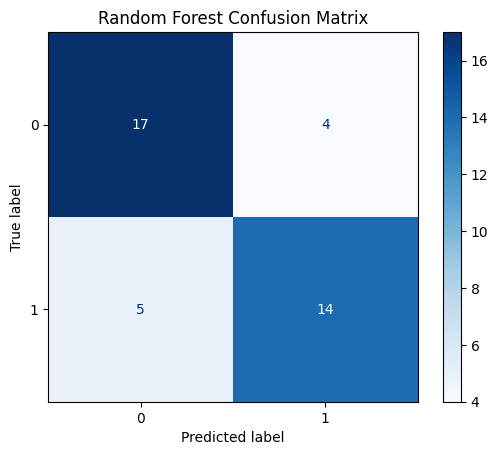

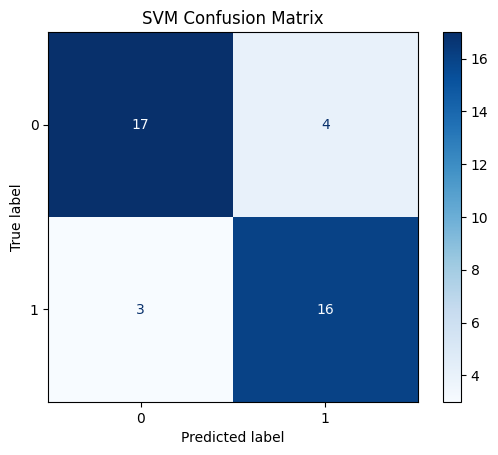

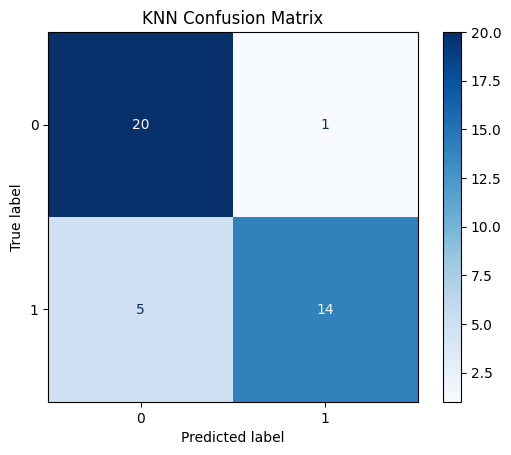

In [40]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")